In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime as dt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

import os
import torch
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
#assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)

C:\Users\DELL\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime as dt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from numpy import savetxt, loadtxt

In [3]:
import dask.dataframe as dd

# Reading data from csv files
def combine_csv_files(csv_files= ['GP9_2020/GP9_202009.csv','GP9_2020/GP9_202010.csv','GP9_2020/GP9_202011.csv','GP9_2020/GP9_202012.csv', 
                          'GP9_2021/GP9_202101.csv','GP9_2021/GP9_202102.csv','GP9_2021/GP9_202103.csv','GP9_2021/GP9_202104.csv',
                          'GP9_2021/GP9_202105.csv','GP9_2021/GP9_202106.csv','GP9_2021/GP9_202107.csv','GP9_2021/GP9_202108.csv',
                          'GP9_2021/GP9_202109.csv','GP9_2021/GP9_202110.csv','GP9_2021/GP9_202111.csv','GP9_2021/GP9_202112.csv',
                          'GP9_2022/GP9_202201.csv','GP9_2022/GP9_202202.csv','GP9_2022/GP9_202203.csv','GP9_2022/GP9_202204.csv',
                          'GP9_2022/GP9_202205.csv','GP9_2022/GP9_202206.csv','GP9_2022/GP9_202207.csv','GP9_2022/GP9_202208.csv',
                          'GP9_2022/GP9_202209.csv','GP9_2022/GP9_202210.csv','GP9_2022/GP9_202211.csv','GP9_2022/GP9_202212.csv',
                          'GP9_2023/GP9_202301.csv','GP9_2023/GP9_202302.csv','GP9_2023/GP9_202303.csv','GP9_2023/GP9_202304.csv']):

#def combine_csv_files(csv_files=['GP9_2023/GP9_202301.csv','GP9_2023/GP9_202302.csv','GP9_2023/GP9_202303.csv','GP9_2023/GP9_202304.csv']):   

    # create an empty list to hold the dataframes
    # columns to read from csv
    cols_to_read = ['Settlement Date', 'GSP Id', 'Settlement Period', 'Meter Volume']
    
    ddf_list = [dd.read_csv(file, header=0, usecols=cols_to_read, 
                            dtype={'Settlement Date': 'uint32', 'GSP Id': 'category', 'Settlement Period': 'int8', 'Meter Volume': 'float32'}) 
                for file in csv_files]
    # concatenate the dask dataframes
    combined_ddf = dd.concat(ddf_list, ignore_index=True)
    #print(combined_ddf.compute().iloc[1])
    
    # drop duplicate rows and sort the resulting dataframe by 'Settlement Date' and 'Settlement Period'
    combined_ddf = combined_ddf.drop_duplicates(split_every=4)
    combined_ddf = combined_ddf.sort_values(['Settlement Date', 'Settlement Period']).reset_index(drop=True)
    combined_ddf = combined_ddf.compute()
    return combined_ddf

combined = combine_csv_files()

In [4]:
#pca = PCA(n_components=2)
#print(combined)

# sort the combined data based on 'GSP Id', 'Settlement Date', 'Settlement Period'
sorted_gsp = combined.sort_values(['GSP Id', 'Settlement Date', 'Settlement Period']).reset_index(drop=True)
print('sorted_gsp: ', sorted_gsp)

#print(sorted_gsp['GSP Id'].unique())

# calculate the unique gsps present in the dataset and storing into a dataframe
unique_gsps = sorted_gsp['GSP Id'].unique()
print('unique_gsps: ', unique_gsps)


sorted_gsp:            Settlement Date  GSP Id  Settlement Period  Meter Volume
0                20180505   ABHA1                  1     54.860001
1                20180505   ABHA1                  2     53.314999
2                20180505   ABHA1                  3     58.205002
3                20180505   ABHA1                  4     58.040001
4                20180505   ABHA1                  5     57.435001
...                   ...     ...                ...           ...
31813876         20230418  SAFO_1                 44     11.830000
31813877         20230418  SAFO_1                 45     10.925000
31813878         20230418  SAFO_1                 46     10.080000
31813879         20230418  SAFO_1                 47      9.340000
31813880         20230418  SAFO_1                 48      8.755000

[31813881 rows x 4 columns]
unique_gsps:  ['ABHA1', 'ABTH_1', 'ACTL_2', 'ACTL_C', 'ALST_3', ..., 'TONG1', 'ROTI3', 'AXMI_H', 'WESA_H', 'SAFO_1']
Length: 367
Categories (367, object):

In [5]:
# most of the gsps are having maximum days as '1810' by observation in the present dataset 
no_of_days = 1810

# initializing a 3D array with zeros having dimensions containing 'GSPs', 'No. of days', 'No. of hrs'
transformed_data = np.zeros((len(unique_gsps), no_of_days, 48))
i = 0
j = 0;

#initializing a gsp variable to contain non zero values
gsps_nonzero = unique_gsps

for each_gsp in unique_gsps:
    # filter each GSP(location) data from the combined sorted dataset
    location_data = sorted_gsp[sorted_gsp['GSP Id'] == str(each_gsp)]
    #print(location_data.shape)
    
    #compute unique dates for each GSP data
    unique_dates= location_data['Settlement Date'].unique()
    print('len(unique_dates): ', len(unique_dates))
    
    #cutfirst = np.empty([1810, 48])
    #print('Empty cutfirst: ', cutfirst)
    
    # considering only the gsp data having no of days greater 
    # or equals to the previously stored number (max no. of days)
    if(len(unique_dates)>= no_of_days):
        
        # initialization
        total_hrs = no_of_days*48
        date_index = 0
        
        for date in unique_dates:
            #print('date: ', date)
            # considering only electricity consumption hourly data ('metered volume ') for each date
            cutfirst1 = location_data[location_data['Settlement Date'] == date]['Meter Volume']
            
            if cutfirst1.size >= 48:
                cutfirst1 = cutfirst1[:48].values.reshape(1, 48)
                
            else:
                while cutfirst1.size < 48 :
                    cutfirst1 = pd.concat([cutfirst1, cutfirst1.tail(1)], axis=0)
                
                cutfirst1 = cutfirst1.values.reshape(1, 48)
            
            if date_index == 0:
                cutfirst = cutfirst1
            else:
                cutfirst = np.append(cutfirst, cutfirst1, axis=0)
                
            date_index += 1
        #print('cutfirst shape: ', cutfirst.shape)
        transformed_data[i] = cutfirst.reshape(1, no_of_days, 48)
        #print(len(cutfirst))
    else:
        j += 1
        print('Number of dates are lesser for GSP index: ', i, 'and the number is: ', len(unique_dates))
        # Deleteing gsps having lesser days(no. of days) than the maximum
        gsps_nonzero = np.delete(gsps_nonzero, np.where(gsps_nonzero == unique_gsps[i]))
    
    i += 1
    #break
    

#newly transformed data shape
print(transformed_data.shape)
print(j)

len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810


len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810
len(unique_dates):  1810


In [6]:
# To consider only nonzero data by truncating last few rows having zero values (corresponding to lesser no. of days)
transformed_data_nonzero = transformed_data[:-j]
print(transformed_data_nonzero.shape)

# Reshaping the transformed data in 2D structure
new = transformed_data_nonzero.reshape(367-j, (no_of_days*48))

new.shape
df = pd.DataFrame(new)

print(df.shape)

(358, 1810, 48)
(358, 86880)


In [9]:
savetxt('data.csv', new, delimiter=',')

In [10]:
savetxt('nonzero_gsps.csv', gsps_nonzero, fmt='%s', delimiter=',')

In [11]:
new = loadtxt('data.csv', delimiter=',')
new.shape

(358, 86880)

In [12]:
gsps_nonzero = loadtxt('nonzero_gsps.csv', dtype=str)
print(gsps_nonzero.shape)

(358,)


In [13]:
data = torch.tensor(new, dtype=torch.get_default_dtype())
# we need to transpose data to correct its shape
y = data.t()

print(y.shape)
print(y.size(0))

torch.Size([86880, 358])
86880


In [14]:
'''
capture_time = y.new_tensor([int(cell_name.split(" ")[0]) for cell_name in df.index.values])
print(capture_time)
# we scale the time into the interval [0, 1]
time = capture_time.log2() / 6
print(time)
'''
# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), 2)  # shape: 367 x 2
#X_prior_mean[:, 0] = time

print(X_prior_mean.shape)

torch.Size([358, 2])


In [15]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))


# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())
#print(X)

# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 32)
print(y)
print(X.shape, y.shape, Xu.shape)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

tensor([[54.8600, 46.6120,  5.2030,  ...,  8.0540,  2.5060, 10.4900],
        [53.3150, 45.0390,  5.3360,  ...,  8.0340,  2.6620, 10.2350],
        [58.2050, 43.9790,  5.3490,  ...,  8.2080,  1.5970,  9.9400],
        ...,
        [57.9850, 44.4900,  7.5250,  ...,  0.8300,  1.0710, 13.0700],
        [54.4800, 39.2400,  7.1730,  ...,  0.7860,  1.2690, 12.5350],
        [51.9250, 38.3100,  6.8870,  ...,  0.6260,  1.7310, 12.0650]])
torch.Size([358, 2]) torch.Size([86880, 358]) torch.Size([32, 2])


In [16]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

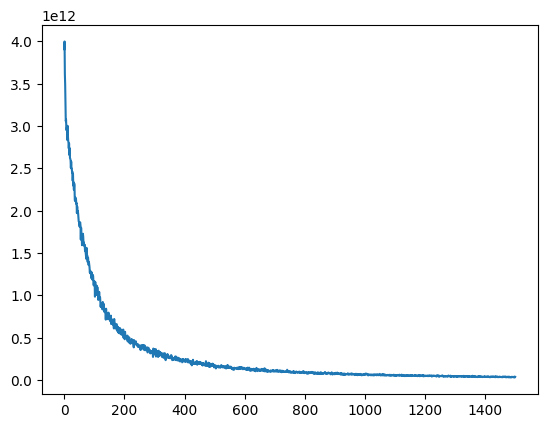

In [17]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=1500)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [18]:
gplvm.mode = "guide"
X_out = gplvm.X  # draw a sample from the guide of the variable X

print(X_out)

tensor([[-1.1496e-01, -8.9923e-02],
        [ 4.2461e-01,  8.7739e-01],
        [-1.1573e+00,  8.5410e-01],
        [-1.8417e+00, -6.6579e+00],
        [-6.3242e+00,  8.5120e+00],
        [-2.1344e+00,  3.0876e-01],
        [-5.5844e+00, -8.4876e+00],
        [-1.1000e+00,  1.3605e+00],
        [ 5.3870e+00,  6.1436e+00],
        [-7.4473e-03, -1.6948e-01],
        [-2.5197e+00,  1.8007e-01],
        [-5.5765e-02, -6.7050e-02],
        [ 9.8346e-02, -1.5388e-01],
        [ 2.7978e-02,  2.1195e-02],
        [-4.0749e-01,  1.0934e+00],
        [ 1.8256e-02,  6.3315e-02],
        [-4.2086e+00, -6.2573e+00],
        [-2.2459e-01,  2.2331e-01],
        [-2.1278e-01,  1.3629e-01],
        [-1.8132e+00, -1.2854e+00],
        [-1.2443e+00, -8.0605e-01],
        [-9.4012e-02,  2.3286e-01],
        [ 1.5251e-01, -7.5379e-01],
        [ 1.1398e-01,  5.4609e-01],
        [ 5.1449e-02, -1.9410e-02],
        [ 1.2717e-02,  1.4588e-01],
        [ 2.3352e-01,  4.2839e-01],
        [-5.1908e-01, -7.458

[1, 2]
torch.Size([358, 2])
(358, 2)


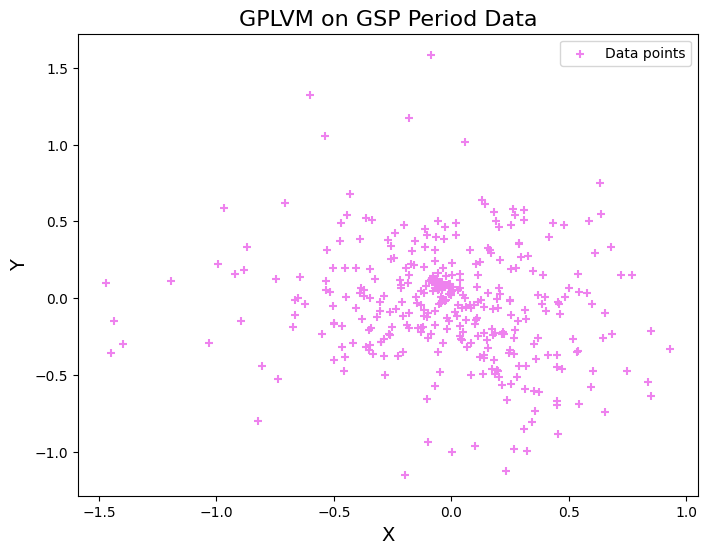

In [19]:
# Visulization part after applying GPLVM on input dataset
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = [1, 2]

print(labels)
print(X_out.shape)
X_out = gplvm.X_loc.detach().numpy()

print(X_out.shape)

'''
for i, label in enumerate(labels):

    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)
'''
plt.scatter(X_out[:, 0], X_out[:, 1], c= 'violet', marker='+', label='Data points')

plt.legend()
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.title("GPLVM on GSP Period Data", fontsize=16)
plt.show()

kmeans.labels:  358
0
157
1
201


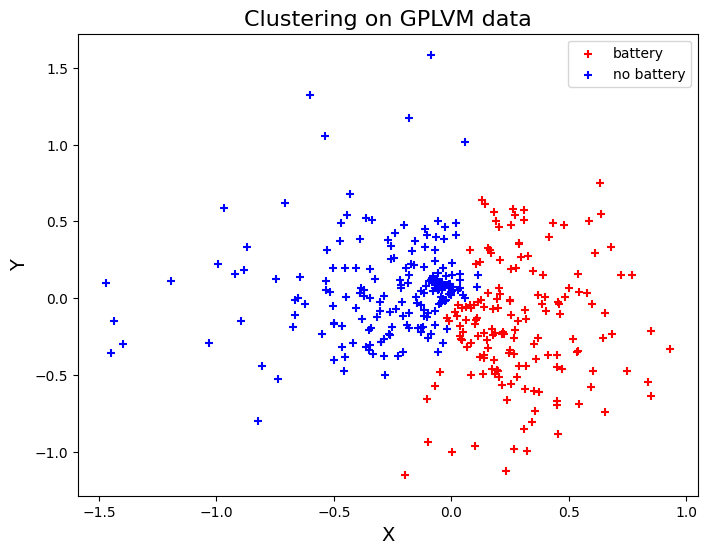

In [20]:
# To perform Clustering after having input data dimension in latent space

k = 2
kmeans = AgglomerativeClustering(n_clusters=k)
kmeans.fit(X_out)
labels = [0, 1]
battery_types = ['battery', 'no battery']
clustered_gsps = []

print('kmeans.labels: ', len(kmeans.labels_))
#colors = cm.spring(np.linspace(0,1,k))
colors=['r','b','y','g','violet', 'cyan']
# Plot the clustered time series data
fig, ax = plt.subplots(figsize=(8, 6))
for i, label in enumerate(labels):
    print(label)
    X_i = X_out[kmeans.labels_ == label]
    print(len(X_i))
    ax.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker='+', label=battery_types[i])
    clustered_gsps.append(gsps_nonzero[kmeans.labels_ == label])

ax.legend()
ax.set_xlabel("X", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.set_title("Clustering on GPLVM data", fontsize=16)
plt.show()

2


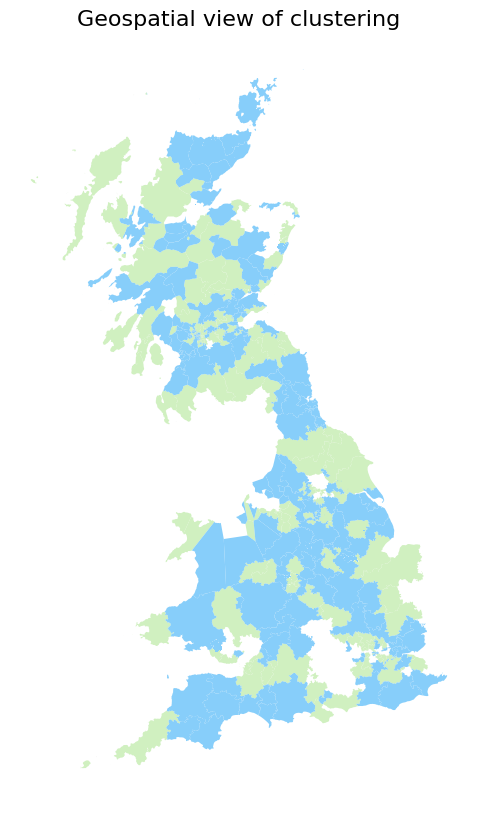

In [21]:
# To visualize the above cluster categories in geospatial map
import geopandas as gpd
from matplotlib.colors import ListedColormap

shapefile = gpd.read_file("../Data/gsp_regions_20220314/GSP_regions_20220314.shp")
print(len(clustered_gsps))

fig, ax = plt.subplots(figsize=(10, 10))
#mycolors = ['#FF6347', '#F62817', '#F9966B', '#E78A61', '#F67280', '#F67280']
mycolors = ['#d0f0c0', '#87cefa']

for each, color in zip(clustered_gsps, mycolors):
    
    filtered = shapefile[shapefile['GSPs'].isin(each)]
    merged = shapefile.merge(filtered)
    merged.plot(ax=ax, cmap=ListedColormap(color))


#ax.legend()
ax.set_xlabel("pseudotime", fontsize=14)
ax.set_ylabel("branching", fontsize=14)
ax.set_title("Geospatial view of clustering", fontsize=16)
plt.axis('off')
plt.show()

In [22]:

for i in range(len(kmeans.labels_)):
    print('GSP: ', unique_gsps[i], 'with label: ', kmeans.labels_[i])

GSP:  ABHA1 with label:  1
GSP:  ABTH_1 with label:  0
GSP:  ACTL_2 with label:  1
GSP:  ACTL_C with label:  1
GSP:  ALST_3 with label:  0
GSP:  ALVE1 with label:  1
GSP:  AMEM_1 with label:  0
GSP:  AXMI1 with label:  1
GSP:  BARKC1 with label:  1
GSP:  BARKW3 with label:  0
GSP:  BEDDT1 with label:  0
GSP:  BEDD_1 with label:  1
GSP:  BESW_1 with label:  0
GSP:  BICF_1 with label:  1
GSP:  BIRK_1 with label:  1
GSP:  BISW_1 with label:  1
GSP:  BLYTB1 with label:  1
GSP:  BLYTH132 with label:  1
GSP:  BOLN_1 with label:  1
GSP:  BOTW_1 with label:  1
GSP:  BRAI_1 with label:  1
GSP:  BRAW_1 with label:  1
GSP:  BRED_1 with label:  0
GSP:  BRFO_1 with label:  1
GSP:  BRIM_1 with label:  0
GSP:  BRLE_1 with label:  1
GSP:  BRWA1 with label:  0
GSP:  BURM_1 with label:  0
GSP:  BUSH_1 with label:  1
GSP:  BUST_1 with label:  0
GSP:  CAMB_01 with label:  0
GSP:  CANTN1 with label:  0
GSP:  CAPEA1 with label:  0
GSP:  CARE_1 with label:  1
GSP:  CARR_1 with label:  0
GSP:  CBNK_H with lab